In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2


In [45]:
#Helper functions

#plot 4 keypoints 
def _4_plot_crane(keypoints_3d):

    # Swap y and z coordinates for all keypoints
    keypoints_3d[:, [1, 2]] = keypoints_3d[:, [2, 1]]

    # Plot the keypoints and the reconstructed crane
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot keypoints
    colors = ['r', 'g', 'b', 'y']
    labels = ['KeyPoint 1', 'KeyPoint 2', 'KeyPoint 3', 'KeyPoint 4']
    for i, keypoint in enumerate(keypoints_3d):
        ax.scatter(*keypoint, color=colors[i], label=labels[i])

    # Plot lines connecting keypoints
    for i in range(len(keypoints_3d) - 1):
        ax.plot([keypoints_3d[i][0], keypoints_3d[i + 1][0]],
                [keypoints_3d[i][1], keypoints_3d[i + 1][1]],
                [keypoints_3d[i][2], keypoints_3d[i + 1][2]], color='k')
    
    # Set axes labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')  # Changed ylabel to represent z-axis
    ax.set_zlabel('Y')  # Changed zlabel to represent y-axis
    ax.legend()
    ax.set_title('3D Coordinate System with KeyPoints')
    plt.show()
#---------------------------------------------------------------------------------

#plot 3 keypoints 
def plot_keypoints_and_lines(keypoints_3d):
    """
    Plot keypoints in 3D and draw lines between them.
    
    Args:
    keypoints_3d: numpy array containing the 3D coordinates of keypoints, in the order:
                  [keypoint1, keypoint2, keypoint3]
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot keypoints
    colors = ['r', 'g', 'b']
    labels = ['KeyPoint 1', 'KeyPoint 2', 'KeyPoint 3']
    for i, keypoint in enumerate(keypoints_3d):
        ax.scatter(keypoint[0], keypoint[2], keypoint[1], color=colors[i], label=labels[i])

    # Plot lines connecting keypoints
    for i in range(len(keypoints_3d) - 1):
        ax.plot([keypoints_3d[i][0], keypoints_3d[i + 1][0]],
                [keypoints_3d[i][2], keypoints_3d[i + 1][2]],
                [keypoints_3d[i][1], keypoints_3d[i + 1][1]], color='k')

    # Set axes labels
    ax.set_xlabel('X')
    ax.set_ylabel('Z')  # Changed ylabel to represent z-axis
    ax.set_zlabel('Y')  # Changed zlabel to represent y-axis
    ax.legend()
    ax.set_title('3D Keypoints and Lines')
    plt.show()



# General Keypoints extraction

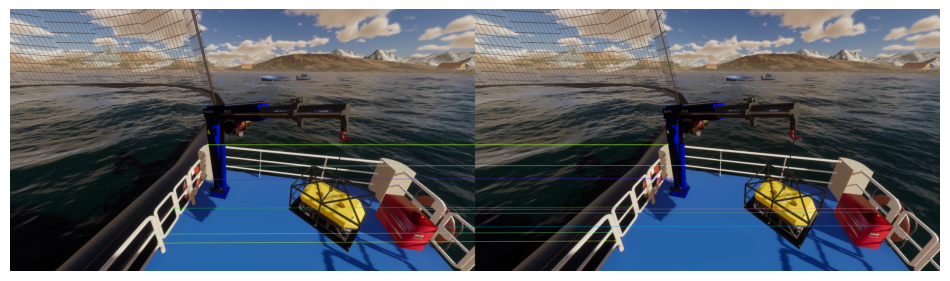

In [2]:
"""import cv2
import matplotlib.pyplot as plt

# Read left and right images
left_image  = 'images/imgl21.png'
right_image = 'images/imgr21.png'
left_img = cv2.imread(left_image)
right_img = cv2.imread(right_image)
# Initialize feature detector and descriptor
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints_left, descriptors_left = orb.detectAndCompute(left_img, None)
keypoints_right, descriptors_right = orb.detectAndCompute(right_img, None)

# Initialize brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors between the two images
matches = bf.match(descriptors_left, descriptors_right)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
matching_result = cv2.drawMatches(left_img, keypoints_left, right_img, keypoints_right, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert matching_result to RGB for displaying with matplotlib
matching_result_rgb = cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB)

# Display result using matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(matching_result_rgb)
plt.axis('off')
plt.show()"""

# Maching defind Keypoints and Triangulation

<IPython.core.display.Javascript object>


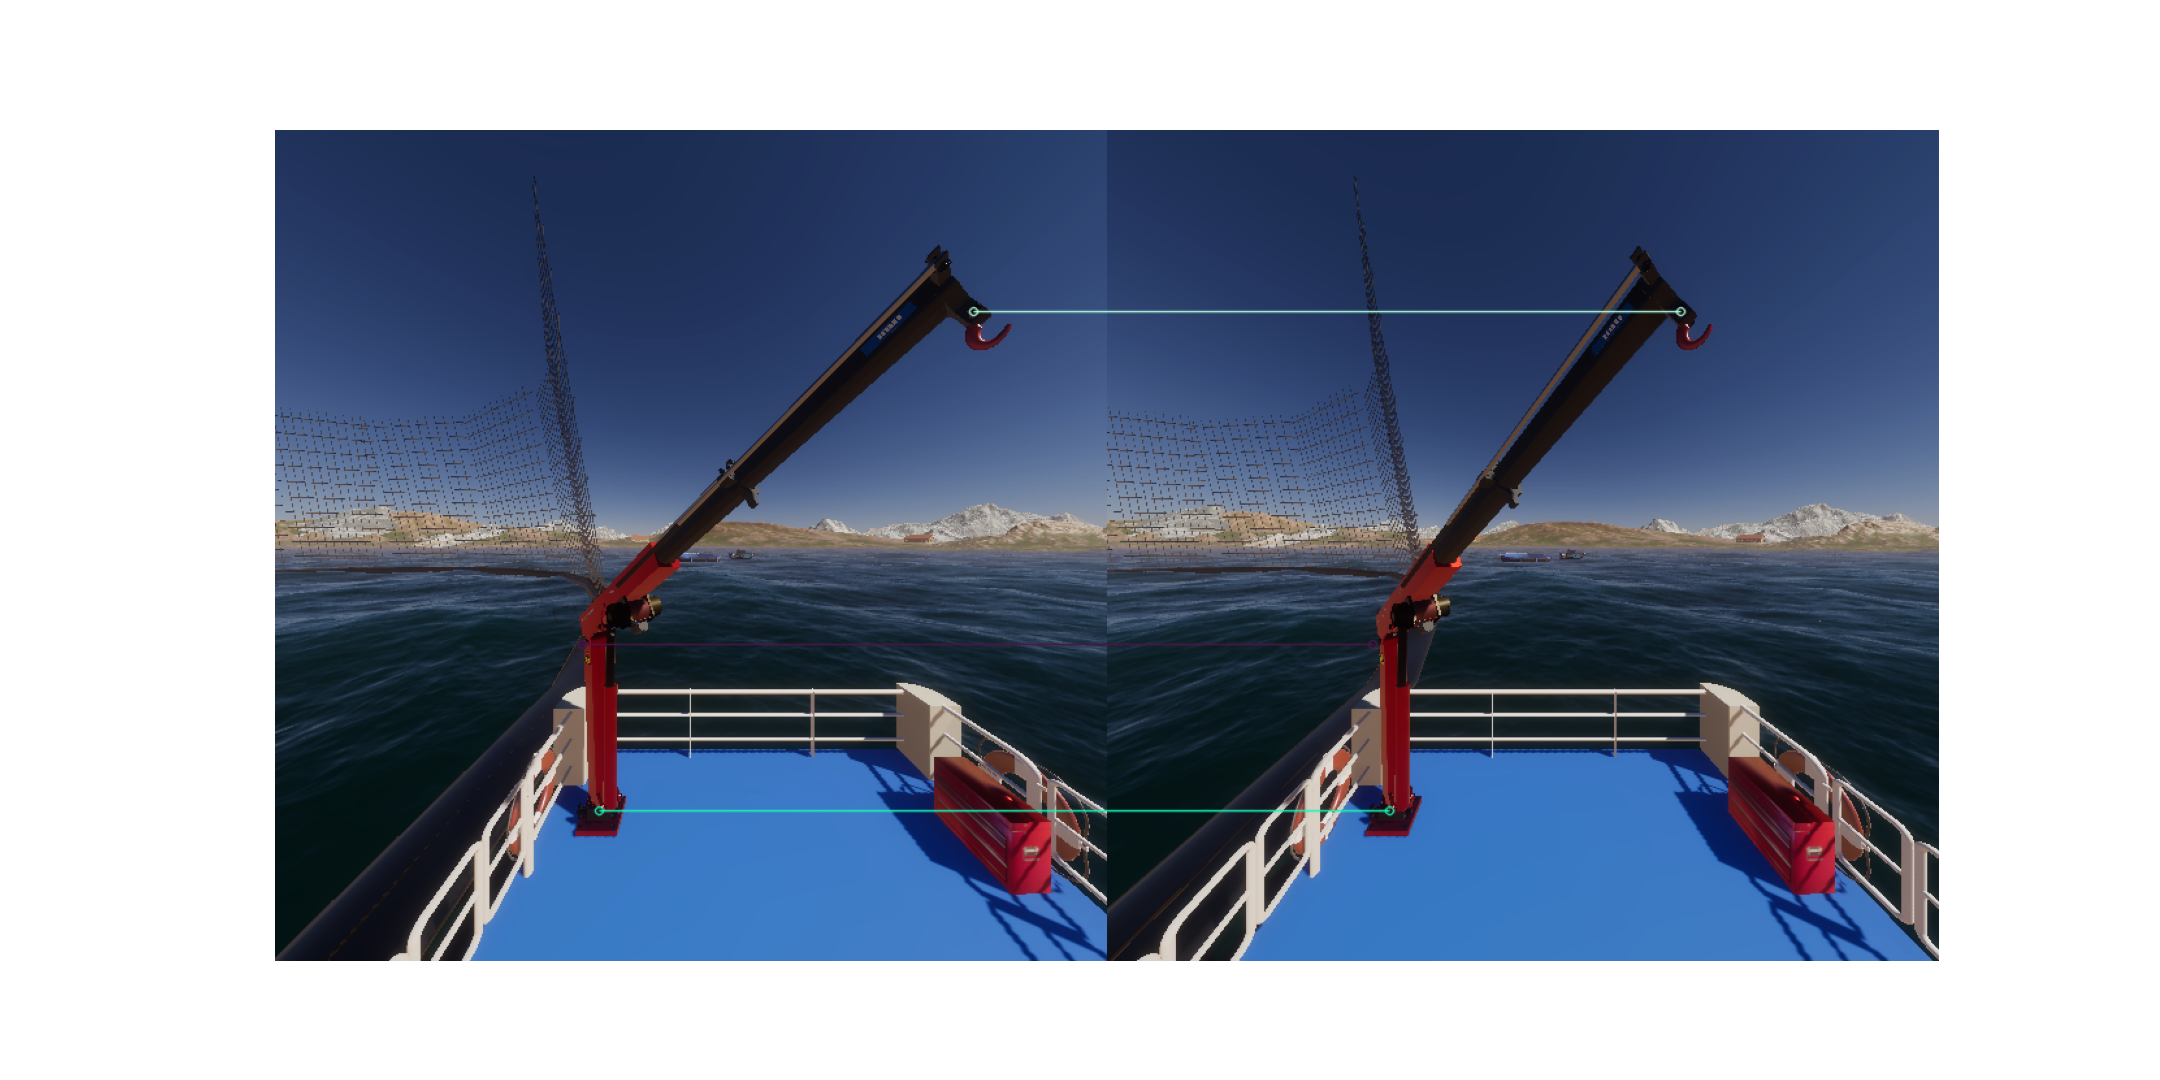

3D Coordinates of KeyPoint 1: [ 13.125  -38.4375 -43.125 ]
3D Coordinates of KeyPoint 2: [ 15.5625 -14.4375 -43.125 ]
3D Coordinates of KeyPoint 3: [-13.625   11.1875 -14.375 ]


In [158]:


# Load left and right images
left_image = 'images/imgl17.png'
right_image = 'images/imgr17.png'
left_img = cv2.imread(left_image)
right_img = cv2.imread(right_image)

#---------------------------------------------------------------------------
# Camera parameters (adjust based on your camera setup)
focal_length = 230
cx = 320                       # Offset from image center in x (pixels)
cy = 320                       # Offset from image center in y (pixels)
baseline_distance = 6      # Distance between camera centers (mm)

#---------------------------------------------------------------------------
# Define keypoints in left and right images (normalized coordinates)
left_keypoints_norm = [(0.39,0.18), (0.37,0.38), (0.84,0.78) ]
right_keypoints_norm =[(0.34,0.18), (0.32,0.38), (0.69,0.78) ] 

#---------------------------------------------------------------------------
# Get image dimensions
left_height, left_width = left_img.shape[:2]
right_height, right_width = right_img.shape[:2]

# Convert normalized keypoints to pixel coordinates
left_keypoints = [(int(x * left_width), int((1 - y) * left_height)) for (x, y) in left_keypoints_norm]
right_keypoints = [(int(x * right_width), int((1 - y) * right_height)) for (x, y) in right_keypoints_norm]

# Convert keypoints to OpenCV KeyPoint objects
left_keypoints_cv2 = [cv2.KeyPoint(x, y, 1) for (x, y) in left_keypoints]
right_keypoints_cv2 = [cv2.KeyPoint(x, y, 1) for (x, y) in right_keypoints]

#---------------------------------------------------------------------------
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
left_keypoints, left_descriptors = sift.compute(left_img, left_keypoints_cv2)
right_keypoints, right_descriptors = sift.compute(right_img, right_keypoints_cv2)

# Initialize feature matcher
bf = cv2.BFMatcher()

# Match features between left and right images
matches = bf.match(left_descriptors, right_descriptors)

# Filter matches to keep only matches corresponding to the defined keypoints
matched_left_keypoints = np.array([left_keypoints[match.queryIdx].pt for match in matches])
matched_right_keypoints = np.array([right_keypoints[match.trainIdx].pt for match in matches])

# Convert matched keypoints to homogeneous coordinates
matched_left_keypoints_homogeneous = np.array([pt + (1,) for pt in matched_left_keypoints]).T
matched_right_keypoints_homogeneous = np.array([pt + (1,) for pt in matched_right_keypoints]).T

#---------------------------------------------------------------------------
# Triangulate keypoints to get 3D points
K = np.array([[focal_length, 0, cx], [0, focal_length, cy], [0, 0, 1]])  # Intrinsic camera matrix
baseline = baseline_distance  # Distance between the cameras

# Calculate projection matrices

# Projection matrices for both cameras
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((np.eye(3), np.array([[baseline_distance], [0], [0]])))



# Triangulate points
points_3d_homogeneous = cv2.triangulatePoints(P1, P2, matched_left_keypoints_homogeneous, matched_right_keypoints_homogeneous)

# Convert homogeneous coordinates to 3D Cartesian coordinates
points_3d_cartesian = points_3d_homogeneous[:3] / points_3d_homogeneous[3]
#points_3d_cartesian[1] *= -1  # Flip the y-coordinate

# Extract 3D coordinates of keypoints
keypoint_1_3d = points_3d_cartesian[:, 0]
keypoint_2_3d = points_3d_cartesian[:, 1]
keypoint_3_3d = points_3d_cartesian[:, 2]



#---------------------------------------------------------------------------
# Draw matched keypoints on the images
matched_img = cv2.drawMatches(left_img, left_keypoints, right_img, right_keypoints, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display result using matplotlib
matched_img_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))
plt.imshow(matched_img_rgb)
plt.axis('off')
plt.show()

# Print 3D coordinates of keypoints
print("3D Coordinates of KeyPoint 1:", keypoint_1_3d)
print("3D Coordinates of KeyPoint 2:", keypoint_2_3d)
print("3D Coordinates of KeyPoint 3:", keypoint_3_3d)



# Reconstructing the 3D Crane

[[-13.3622  -38.68844  40.27901]
 [-16.52493 -15.09     43.48545]
 [ 13.39371  11.17762  13.08188]]


<IPython.core.display.Javascript object>


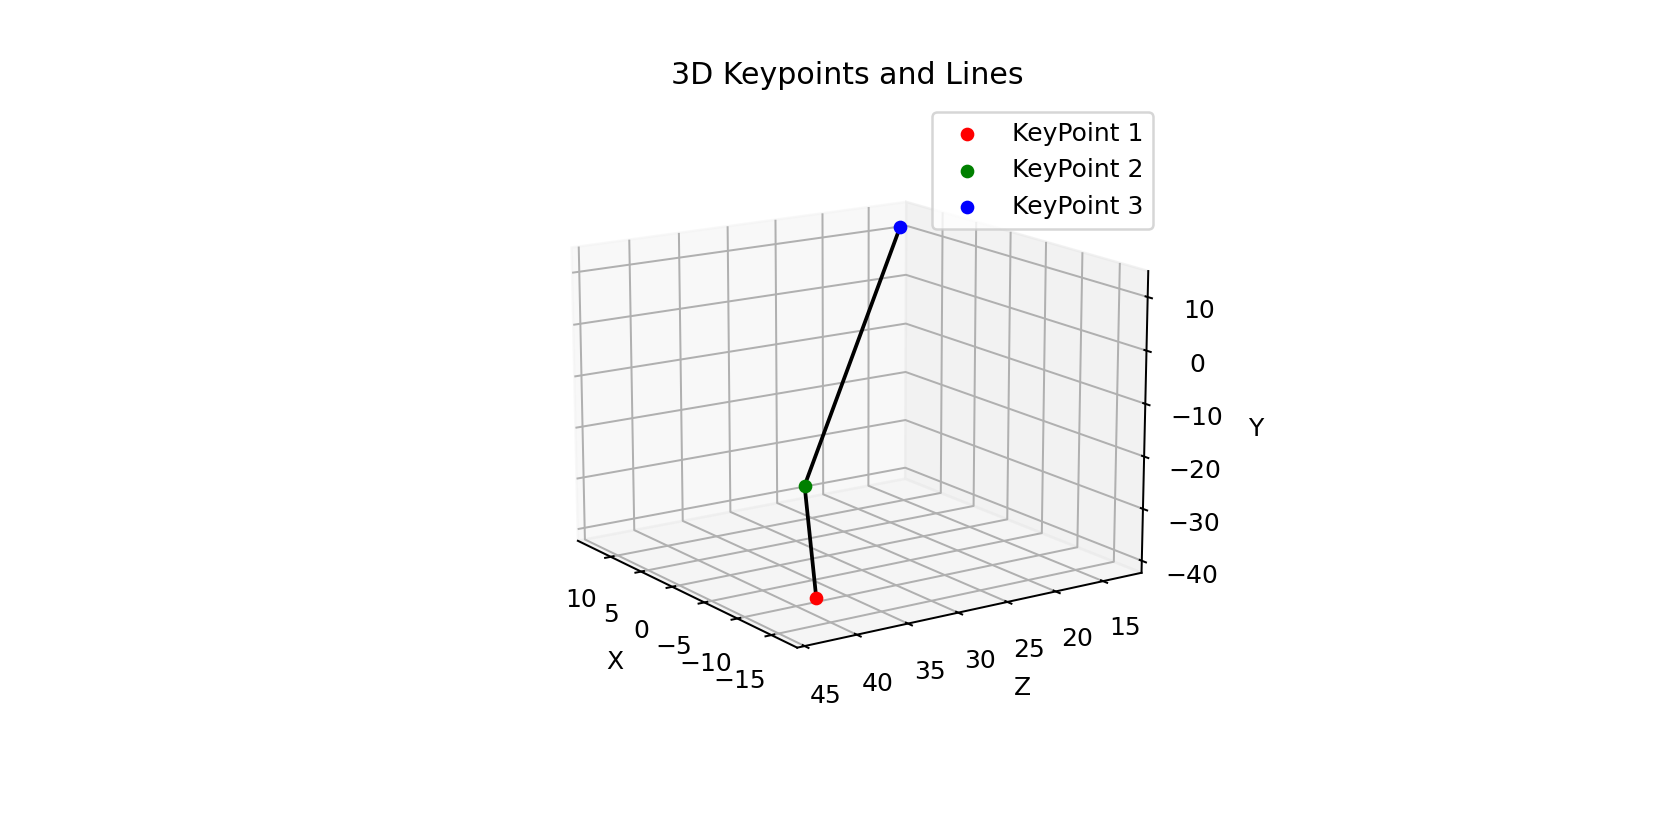

In [143]:
#actual 3D coordinates to have an idea

keypoint_1 = [-13.3622, -38.68844, 40.27901]
keypoint_2 = [-16.52493, -15.09, 43.48545]
keypoint_3 = [13.39371, 11.17762, 13.08188]



keypoints_3d = np.array([keypoint_1, keypoint_2, keypoint_3])
print(keypoints_3d)

plot_keypoints_and_lines(keypoints_3d)


[[-13.2   -38.4    43.125]
 [-15.6   -14.4    43.125]
 [ 13.6    11.2    14.375]]


<IPython.core.display.Javascript object>


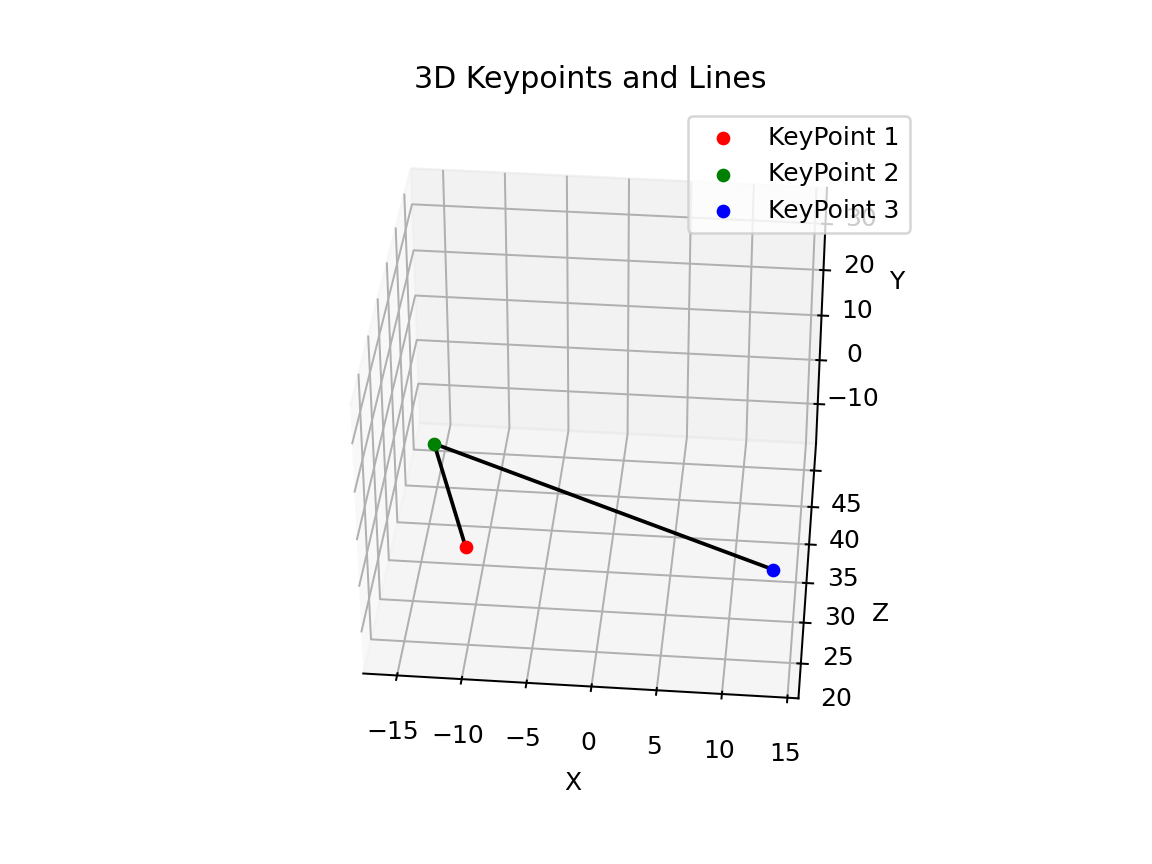

'[[-13.3622  -38.68844  40.27901]\n [-16.52493 -15.09     43.48545]\n [ 13.39371  11.17762  13.08188]]'

In [168]:
# Define camera parameters
focal_length = 230  # Focal length in mm
cx = 320  # Principal point offset x
cy = 320  # Principal point offset y
baseline_distance = 6  # Baseline distance in mm
image_size = 640  # Image dimension size (assuming square images)


# Normalized keypoints for left and right images
left_keypoints_norm = [(0.39,0.18), (0.37,0.38), (0.84,0.78) ]
right_keypoints_norm =[(0.34,0.18), (0.32,0.38), (0.69,0.78) ] 

# Function to convert normalized keypoints to pixel coordinates
def convert_to_pixel_coordinates(normalized_keypoints, image_size):
    return [(x * image_size, y * image_size) for x, y in normalized_keypoints]

# Function to calculate 3D positions from stereo image keypoints
def calculate_3d_positions(left_keypoints_pixel, right_keypoints_pixel, focal_length, cx, cy, baseline_distance):
    # Calculate disparity and depth for each keypoint
    disparities = [left[0] - right[0] for left, right in zip(left_keypoints_pixel, right_keypoints_pixel)]
    depths = [focal_length * baseline_distance / disparity for disparity in disparities]
    
    # Calculate the 3D positions (X, Y, Z) for each keypoint
    keypoints_3d = [
        (
            ((x - cx) * depth / focal_length),
            ((y - cy) * depth / focal_length),
            depth
        ) 
        for (x, y), depth in zip(left_keypoints_pixel, depths)
    ]
    
    return keypoints_3d

# Convert normalized keypoints to pixel coordinates
left_keypoints_pixel = convert_to_pixel_coordinates(left_keypoints_norm, image_size)
right_keypoints_pixel = convert_to_pixel_coordinates(right_keypoints_norm, image_size)
#print(left_keypoints_pixel)
# Calculate 3D positions of the keypoints
keypoints_3d = calculate_3d_positions(left_keypoints_pixel, right_keypoints_pixel, focal_length, cx, cy, baseline_distance)

print(np.array(keypoints_3d))



keypoints1_3d = np.array([keypoint_1, keypoint_2, keypoint_3])

# Plot the keypoints and draw lines between them
plot_keypoints_and_lines(np.array(keypoints_3d))

"""[[-13.3622  -38.68844  40.27901]
 [-16.52493 -15.09     43.48545]
 [ 13.39371  11.17762  13.08188]]"""